## Algoritmo Genético

No jupyter anterior utilizamos o algoritmo Gradiente Decrescente para otimizar a função objetivo, afim de comparações, dessa vez utilizaremos um algoritmo genético.

In [1]:
from random import randint, uniform, random
from tqdm import tqdm
import numpy as np

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/10
    
    tempo = iteracao/10
    
    tempoInicialAnalise = 0.0
    tempoFinalAnalise = 0.2
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.1
    tempoFinalAnalise += 0.1
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/10
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*10)]], [x[int(tempoInicialAnalise*10)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.1
        tempoFinalAnalise += 0.1
    
    return y

In [3]:
# Parâmetros iniciais

tamanhoPopulacao = 30
taxaMutacao = 0.01
taxaCrossover = 0.70
numeroGeracoes = 70
quantidadeVariaveis = 10 # Para o sistema dinâmico avaliado, apenas os controles devem ser avaliados
quantidadeTrocas = 2 # Posicoes a serem trocadas na 

In [4]:
def gerarPopulacao(xMin, xMax):
    populacao = np.zeros((tamanhoPopulacao,quantidadeVariaveis))
    for individuo in range(tamanhoPopulacao):
        for pos in range(quantidadeVariaveis):
            populacao[individuo,pos] = uniform(xMin, xMax)
    return populacao

In [5]:
def divisaoFitness(valorFuncaoObjetivo):
    divisao = 0
    for i in range(len(valorFuncaoObjetivo)):
        divisao += valorFuncaoObjetivo[i]
    return divisao

def fitness(valorFuncaoObjetivo):
    return valorFuncaoObjetivo/divisaoFitness(valorFuncaoObjetivo)

In [6]:
def calcularFuncao(populacao, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise):
    valorFuncaoObj = np.zeros(tamanhoPopulacao)
    for individuo in range(tamanhoPopulacao):
        valorFuncaoObj[individuo] = funcaoObjetivo(populacao[individuo,:], iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    return valorFuncaoObj

In [7]:
def selecao(valorFitness):
    pos = np.random.choice(range(tamanhoPopulacao), 2, replace=False)
    valor = valorFitness[pos[0]] < valorFitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [8]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [9]:
def mutacao(individuo):
    
    for i in range (0, quantidadeVariaveis):
        if random() < taxaMutacao:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(0, 10)-2)**2))
    
    return individuo

In [10]:
import matplotlib.pyplot as plt

In [11]:
def main(xMin, xMax, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise):
    pop = gerarPopulacao(xMin, xMax)
    fo = calcularFuncao(pop, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    fit = fitness(fo)
    melhor_fo = np.zeros(numeroGeracoes)
    melhor_ind_geracao = np.zeros((numeroGeracoes, quantidadeVariaveis))
    for geracao in range(numeroGeracoes):
        new_pop = np.empty((0, quantidadeVariaveis))
        for i in range(round((tamanhoPopulacao) / 2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < taxaCrossover:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])     
                filho1 = mutacao(filho1)
                filho2 = mutacao(filho2)  
                new_pop = np.vstack([new_pop, filho1, filho2])     
            else:
                pais = np.vstack([mutacao(pop[pai1, :]), mutacao(pop[pai2, :])])
                new_pop = np.vstack([new_pop, pais])
        pop = new_pop    
        fo = calcularFuncao(pop, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)

    
    #plt.plot(melhor_fo)
    #plt.xlim(0, numeroGeracoes)
    #plt.ylabel('Gerações')
    #plt.ylabel('Melhor Custo')
    #plt.title('Evolução da função objetivo - GA')
    #plt.grid(True)
    #plt.show()
    

    return pop[pos_min_fo,:][0,0]

In [12]:
# Função de origem e destino
ondaOrigem = [[complex(1.0,0.0)],[complex(0.0,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]

valoresOnda3 = np.zeros((2, 200), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,200), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

hamiltoniano = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
hamiltoniano = [[A, 0], [0, B]]

iteracao = 0
fatorRungeKutta = 0.1
tempoAnalise = 200
horizonte = 10

xMin = -10
xMax = 10

constantes3 = np.zeros((2, 200), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1

minimo = main(xMin, xMax, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

In [13]:
minimo

array([ 0.01792713, -1.3703987 ,  3.03465415,  0.87800333,  2.05171182,
        4.74711731, -0.79302062,  0.00783652,  1.27728743,  0.89226404])

In [14]:
while iteracao < 200:
    
    print(f"Iteração: {iteracao}")
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, minimo[0]],[minimo[0],0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]

    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
    
    ## Adaptação da onda ao controle
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(minimo, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.2, tempoInicial = 0)

    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]

    xMax = 10
    xMin = -10
    
    A = (1/2*np.pi)
    B = (3/2*np.pi)
    hamiltoniano = [[A, 0], [0, B]]
    
    iteracao += 1

    minimo = main(xMax, xMin, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)

Iteração: 0
Iteração: 1
Iteração: 2
Iteração: 3
Iteração: 4
Iteração: 5
Iteração: 6
Iteração: 7
Iteração: 8
Iteração: 9
Iteração: 10
Iteração: 11
Iteração: 12
Iteração: 13
Iteração: 14
Iteração: 15
Iteração: 16
Iteração: 17
Iteração: 18
Iteração: 19
Iteração: 20
Iteração: 21
Iteração: 22
Iteração: 23
Iteração: 24
Iteração: 25
Iteração: 26
Iteração: 27
Iteração: 28
Iteração: 29
Iteração: 30
Iteração: 31
Iteração: 32
Iteração: 33
Iteração: 34
Iteração: 35
Iteração: 36
Iteração: 37
Iteração: 38
Iteração: 39
Iteração: 40
Iteração: 41
Iteração: 42
Iteração: 43
Iteração: 44
Iteração: 45
Iteração: 46
Iteração: 47
Iteração: 48
Iteração: 49
Iteração: 50
Iteração: 51
Iteração: 52
Iteração: 53
Iteração: 54
Iteração: 55
Iteração: 56
Iteração: 57
Iteração: 58
Iteração: 59
Iteração: 60
Iteração: 61
Iteração: 62
Iteração: 63
Iteração: 64
Iteração: 65
Iteração: 66
Iteração: 67
Iteração: 68
Iteração: 69
Iteração: 70
Iteração: 71
Iteração: 72
Iteração: 73
Iteração: 74
Iteração: 75
Iteração: 76
Iteração:

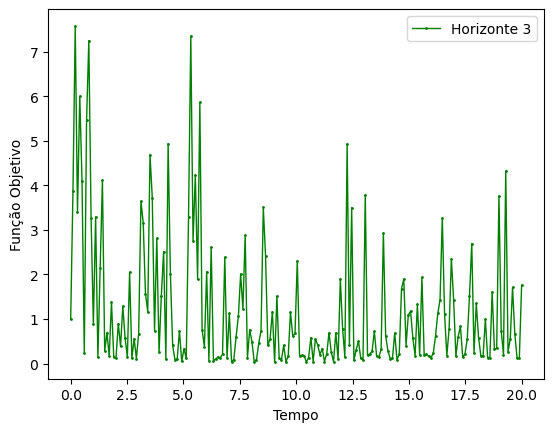

In [15]:
ts = np.linspace(0, 20, 200) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0])/abs(valoresFuncaoObjetivo3[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.legend(loc="upper right")
plt.show()

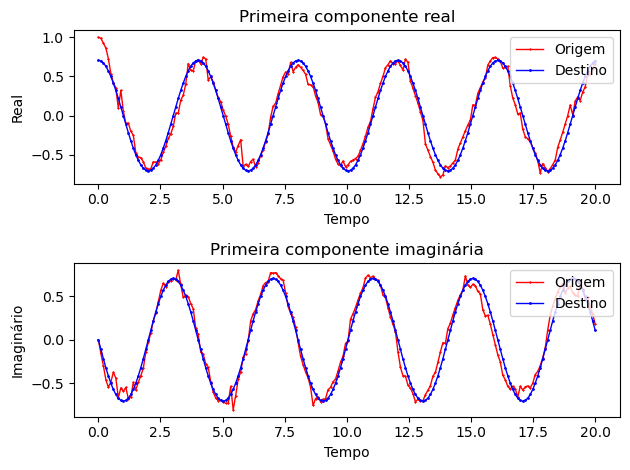

In [16]:
tempo = np.linspace(0, 20, 200)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,200), dtype=np.complex_)
for i in range(0, 200):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/10))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/10))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()
